In [27]:
!nvidia-smi

Fri Jun 10 13:24:45 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.142.00   Driver Version: 450.142.00   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:1E.0 Off |                    0 |
| N/A   49C    P0    27W /  70W |  10761MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Settings

In [2]:
import warnings
warnings.filterwarnings('ignore')

from glob import glob
import pandas as pd
import numpy as np 
from tqdm import tqdm
import cv2

import os
import timm
import random

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torchvision.transforms as transforms
from sklearn.metrics import f1_score, accuracy_score
import time

from sklearn.model_selection import StratifiedKFold
device = torch.device('cuda')

## Image Pre-Process

In [3]:
train_png = sorted(glob('/home/lab17/jupyter_home/Data/bdata_snacks/*.jpg'))
test_png = sorted(glob('/home/lab17/jupyter_home/git/git_jy/test_dataset/*.jpg'))

# files = os.listdir('/home/lab17/jupyter_home/Data/bdata_snacks')
# files

In [4]:
print(len(train_png), len(set(train_png)))
print(len(test_png), len(set(test_png)))

311 311
7 7


In [5]:
# decoder
files = os.listdir('/home/lab17/jupyter_home/Data/bdata_snacks')
train_labels = sorted(files)
train_dict = {i:l[:-4] for i, l in zip(range(311), train_labels)}

In [6]:
def img_load(path):
    img = cv2.imread(path)[:,:,::-1]
    img = cv2.resize(img, (384, 384),interpolation = cv2.INTER_AREA)
    return img

In [9]:
train_imgs = [img_load(m) for m in tqdm(train_png)]
test_imgs = [img_load(n) for n in tqdm(test_png)]



  0%|                                                   | 0/311 [00:00<?, ?it/s]

  0%|▏                                          | 1/311 [00:00<00:41,  7.42it/s]

  1%|▎                                          | 2/311 [00:00<00:37,  8.26it/s]

  1%|▌                                          | 4/311 [00:00<00:28, 10.72it/s]

  2%|▊                                          | 6/311 [00:00<00:26, 11.72it/s]

  3%|█                                          | 8/311 [00:00<00:24, 12.13it/s]

  3%|█▎                                        | 10/311 [00:00<00:23, 12.62it/s]

  4%|█▌                                        | 12/311 [00:01<00:27, 10.88it/s]

  5%|█▉                                        | 14/311 [00:01<00:25, 11.60it/s]

  5%|██▏                                       | 16/311 [00:01<00:26, 10.97it/s]

  6%|██▍                                       | 18/311 [00:01<00:24, 11.81it/s]

  6%|██▋                                       | 20/311 [00:01<00:22, 13.08it/s]

KeyboardInterrupt: 

In [32]:
np.save('/home/lab17/jupyter_home/Data/bdata_snacks_384.npy', np.array(train_imgs))
np.save('/home/lab17/jupyter_home/Data/test_snacks_384.npy', np.array(test_imgs))

In [10]:
train_imgs = np.load('/home/lab17/jupyter_home/Data/bdata_snacks_384.npy')
test_imgs = np.load('/home/lab17/jupyter_home/Data/test_snacks_384.npy')

 14%|█████▊                                    | 43/311 [00:14<00:24, 11.03it/s]

In [13]:
# meanRGB = [np.mean(x, axis=(0,1)) for x in train_imgs]
# stdRGB = [np.std(x, axis=(0,1)) for x in train_imgs]

# meanR = np.mean([m[0] for m in meanRGB])/255
# meanG = np.mean([m[1] for m in meanRGB])/255
# meanB = np.mean([m[2] for m in meanRGB])/255

# stdR = np.mean([s[0] for s in stdRGB])/255
# stdG = np.mean([s[1] for s in stdRGB])/255
# stdB = np.mean([s[2] for s in stdRGB])/255

# print("train 평균",meanR, meanG, meanB)
# print("train 표준편차",stdR, stdG, stdB)

train 평균 0.7097844470485838 0.633531969760679 0.5547763538712672
train 표준편차 0.2033680463341466 0.21580010480417353 0.24844798400637713


In [34]:
# meanRGB = [np.mean(x, axis=(0,1)) for x in test_imgs]
# stdRGB = [np.std(x, axis=(0,1)) for x in test_imgs]

# meanR = np.mean([m[0] for m in meanRGB])/255
# meanG = np.mean([m[1] for m in meanRGB])/255
# meanB = np.mean([m[2] for m in meanRGB])/255

# stdR = np.mean([s[0] for s in stdRGB])/255
# stdG = np.mean([s[1] for s in stdRGB])/255
# stdB = np.mean([s[2] for s in stdRGB])/255

# print("test 평균",meanR, meanG, meanB)
# print("test 표준편차",stdR, stdG, stdB)

test 평균 0.5675011557357318 0.5264908952947499 0.42253120486475837
test 표준편차 0.2274250397086117 0.23777227831017764 0.25968101419272444


## Model Define

In [11]:
class Custom_dataset(Dataset):
    def __init__(self, img_paths, labels, mode='train'):
        self.img_paths = img_paths
        self.labels = labels
        self.mode=mode
    def __len__(self):
        return len(self.img_paths)
    def __getitem__(self, idx):
        img = self.img_paths[idx]
        if self.mode == 'train':
            train_transform = transforms.Compose([
                transforms.ToTensor(),
#                 transforms.Normalize(mean = [0.709784, 0.633531, 0.554776],
#                                     std = [0.203368, 0.215800, 0.248448]),
                transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
                transforms.RandomCrop(224),
                transforms.RandomPerspective(),
                transforms.RandomAffine((-45, 45)),  # x, y축으로 이미지 늘림
                transforms.RandomRotation((0,80)),
                transforms.ColorJitter(brightness=0.5),
            ])


#             train_transform = transforms.Compose([
#                 transforms.ToTensor(),
#                 transforms.Normalize(mean = [0.709784, 0.633531, 0.554776],
#                                     std = [0.203368, 0.215800, 0.248448]),
#                 transforms.RandomAffine((-45, 45)),
#                 transforms.RandomRotation((0,80))       #  이미지를 랜덤으로 degrees 각도로 회전한다.
#             ])

            img = train_transform(img)
        if self.mode == 'test':
            test_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean = [0.567501, 0.526491, 0.422531],
                                     std = [0.227425, 0.237772, 0.259681]),
                

            ])
            img = test_transform(img)

        
        label = self.labels[idx]
        return img, label
    
class Network(nn.Module):
    def __init__(self,mode = 'train'):
        super(Network, self).__init__()
        self.mode = mode
        if self.mode == 'train':
          self.model = timm.create_model('efficientnet_b4', pretrained=True, num_classes=311, drop_path_rate = 0.2)
        if self.mode == 'test':
          self.model = timm.create_model('efficientnet_b4', pretrained=True, num_classes=311, drop_path_rate = 0)
        
    def forward(self, x):
        x = self.model(x)
        return x

In [12]:
def score_function(real, pred):
#     score = f1_score(real, pred, average="macro")
    score = accuracy_score(real, pred)
    return score

In [13]:
def main(seed = 2022):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = True
    
main(2022)



  6%|██▋                                       | 20/311 [00:19<00:22, 13.08it/s]

In [16]:
train_dataset = Custom_dataset(np.array(train_imgs), np.array(list(train_dict.keys())), mode='train')
train_loader = DataLoader(train_dataset, shuffle=False, batch_size=34)

dataiter = iter(train_loader)
images, labels = dataiter.next()
images.size()

torch.Size([34, 3, 224, 224])

 14%|█████▉                                    | 44/311 [03:10<19:16,  4.33s/it]


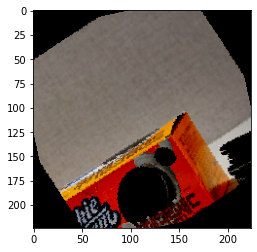

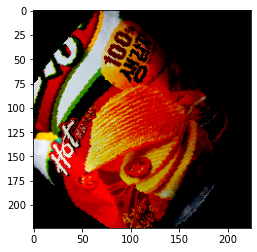

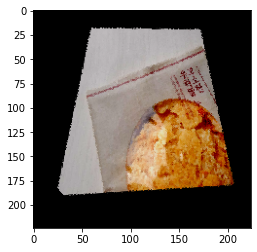

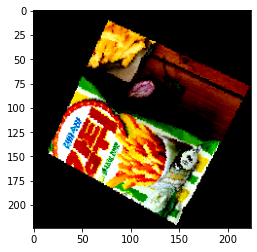

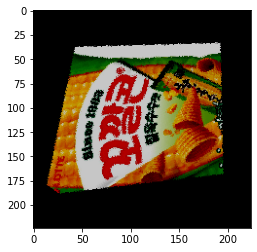

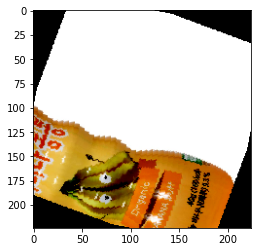

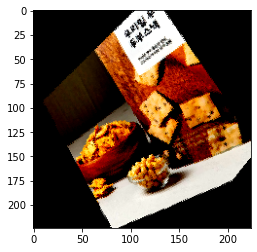

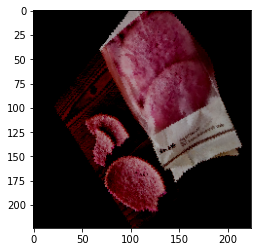

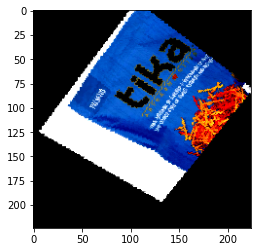

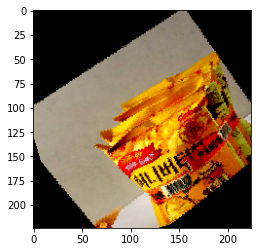

In [18]:
import matplotlib.pyplot as plt

def custom_imshow(img):
    img = img.numpy()
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()
    
def process():
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        custom_imshow(inputs[0])

process()

## Train

In [16]:
import gc

batch_size = 34
epochs = 70
pred_ensemble = []

# Train
train_dataset = Custom_dataset(np.array(train_imgs), np.array(list(train_dict.keys())), mode='train')
train_loader = DataLoader(train_dataset, shuffle=False, batch_size=batch_size)

# # Val
# val_dataset = Custom_dataset(np.array(val_imgs), np.array(val_labels), np.array([]), mode='test')
# val_loader = DataLoader(val_dataset, shuffle=True, batch_size=batch_size)

gc.collect()
torch.cuda.empty_cache()
best=0

model = Network().to(device)

# optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay = 2e-2)
optimizer = torch.optim.Adadelta(model.parameters())
criterion = nn.CrossEntropyLoss()
scaler = torch.cuda.amp.GradScaler()  

# Data 저장
save_loss = []
save_acc = []

best_f1 = 0
early_stopping = 0
for epoch in range(epochs):
    start=time.time()
    train_loss = 0
    train_pred=[]
    train_y=[]
    model.train()
    for batch in (train_loader):
        optimizer.zero_grad()
        x = torch.tensor(batch[0], dtype=torch.float32, device=device)
        y = torch.tensor(batch[1], dtype=torch.long, device=device)
        with torch.cuda.amp.autocast():
            pred = model(x)
        loss = criterion(pred, y)


        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()/len(train_loader)
        train_pred += pred.argmax(1).detach().cpu().numpy().tolist()
        train_y += y.detach().cpu().numpy().tolist()
        
    train_acc = score_function(train_y, train_pred)
    state_dict= model.state_dict()
    model.eval()
    
    save_loss.append(train_loss)
    save_acc.append(train_acc)

    TIME = time.time() - start
    print(f'epoch : {epoch+1}/{epochs}    time : {TIME:.0f}s/{TIME*(epochs-epoch-1):.0f}s')
    print(f'TRAIN    loss : {train_loss:.5f}    acc : {train_acc:.5f}')
#     print(f'Val    loss : {val_loss:.5f}    f1 : {val_f1:.5f}')

epoch : 1/70    time : 5s/356s
TRAIN    loss : 5.78672    acc : 0.00000
epoch : 2/70    time : 5s/344s
TRAIN    loss : 5.70625    acc : 0.01608
epoch : 3/70    time : 5s/340s
TRAIN    loss : 5.60625    acc : 0.02251
epoch : 4/70    time : 5s/335s
TRAIN    loss : 5.46133    acc : 0.03537
epoch : 5/70    time : 5s/325s
TRAIN    loss : 5.34492    acc : 0.05466
epoch : 6/70    time : 5s/324s
TRAIN    loss : 5.14824    acc : 0.05788
epoch : 7/70    time : 5s/312s
TRAIN    loss : 4.81113    acc : 0.05466
epoch : 8/70    time : 5s/309s
TRAIN    loss : 4.49414    acc : 0.19614
epoch : 9/70    time : 5s/302s
TRAIN    loss : 3.80825    acc : 0.21222
epoch : 10/70    time : 5s/297s
TRAIN    loss : 3.03960    acc : 0.34727
epoch : 11/70    time : 5s/294s
TRAIN    loss : 2.12970    acc : 0.46945
epoch : 12/70    time : 5s/288s
TRAIN    loss : 1.36969    acc : 0.65916
epoch : 13/70    time : 5s/285s
TRAIN    loss : 0.84207    acc : 0.81029
epoch : 14/70    time : 5s/280s
TRAIN    loss : 0.54709    a

In [17]:
print(save_loss)
print(save_acc)

[5.78671875, 5.70625, 5.60625, 5.4613281250000005, 5.344921875000001, 5.1482421875, 4.8111328125, 4.494140625, 3.808251953125, 3.039599609375, 2.1296966552734373, 1.36968994140625, 0.8420745849609376, 0.5470939636230469, 0.370330810546875, 0.38782958984375, 0.2555809020996093, 0.18983764648437504, 0.24632110595703122, 0.12639713287353516, 0.14674758911132812, 0.11262931823730468, 0.09833574295043944, 0.09057273864746093, 0.08996720314025877, 0.0957857131958008, 0.09041290283203125, 0.07904529571533203, 0.06045846939086914, 0.08192589282989504, 0.06433944702148438, 0.0364778995513916, 0.07313232421874999, 0.060389518737792976, 0.026785659790039062, 0.03984794616699219, 0.020212543010711667, 0.08311119079589843, 0.03931097984313965, 0.032078123092651366, 0.029092407226562502, 0.027066445350646968, 0.05170383453369141, 0.04822121858596801, 0.03518122434616088, 0.02673435211181641, 0.02355003356933594, 0.034409713745117185, 0.02312984466552734, 0.01326698064804077, 0.007684707641601563, 0.

In [23]:
x = range(70)
norm_loss = [5.7894531250000005, 5.71015625, 5.6203125, 5.5093749999999995, 5.337890625, 5.2250000000000005, 5.033203125000001, 4.5277343750000005, 3.99658203125, 3.4169921875000004, 2.6811096191406247, 1.7805175781249998, 1.01136474609375, 0.73671875, 0.4466064453125, 0.395635986328125, 0.3535346984863281, 0.24943237304687502, 0.22591247558593747, 0.20437240600585938, 0.1760652542114258, 0.11902098655700684, 0.12204449176788329, 0.1137481689453125, 0.11482696533203124, 0.11692352294921875, 0.09194545745849608, 0.05409965515136719, 0.06304035186767579, 0.09681968688964843, 0.0918254852294922, 0.09844002723693848, 0.056616497039794926, 0.0678955078125, 0.054180145263671875, 0.059410667419433585, 0.020106470584869383, 0.03597445487976074, 0.07469942569732667, 0.05358932018280029, 0.044331359863281246, 0.048507952690124506, 0.03670549392700195, 0.028630089759826664, 0.024741637706756595, 0.046455764770507814, 0.021665501594543456, 0.016525840759277342, 0.03212469816207886, 0.01492409706115723, 0.015300118923187257, 0.015032410621643065, 0.02420120239257812, 0.017638933658599854, 0.01750802993774414, 0.013071739673614503, 0.023575496673583985, 0.025659590959548947, 0.025334787368774418, 0.010526883602142335, 0.010084152221679688, 0.006743001937866212, 0.016949415206909183, 0.03416758775711059, 0.016322803497314454, 0.014030802249908447, 0.011750674247741701, 0.009301376342773436, 0.007197332382202147, 0.00564085841178894]
norm_acc = [0.003215434083601286, 0.012861736334405145, 0.01607717041800643, 0.04823151125401929, 0.05466237942122187, 0.08038585209003216, 0.17041800643086816, 0.13183279742765272, 0.1607717041800643, 0.3054662379421222, 0.40192926045016075, 0.5594855305466238, 0.752411575562701, 0.8263665594855305, 0.9035369774919614, 0.8938906752411575, 0.9196141479099679, 0.9356913183279743, 0.9517684887459807, 0.9356913183279743, 0.9453376205787781, 0.9646302250803859, 0.9710610932475884, 0.9742765273311897, 0.9646302250803859, 0.9678456591639871, 0.977491961414791, 0.9871382636655949, 0.9871382636655949, 0.9710610932475884, 0.9581993569131833, 0.9678456591639871, 0.9807073954983923, 0.977491961414791, 0.9807073954983923, 0.9871382636655949, 0.9967845659163987, 0.9871382636655949, 0.9742765273311897, 0.9807073954983923, 0.9871382636655949, 0.9903536977491961, 0.9871382636655949, 0.9903536977491961, 0.9935691318327974, 0.9903536977491961, 0.9935691318327974, 1.0, 0.9903536977491961, 0.9935691318327974, 0.9935691318327974, 0.9967845659163987, 0.9903536977491961, 0.9967845659163987, 0.9935691318327974, 0.9967845659163987, 0.9903536977491961, 0.9967845659163987, 0.9935691318327974, 1.0, 0.9967845659163987, 1.0, 0.9935691318327974, 0.9935691318327974, 0.9967845659163987, 0.9967845659163987, 0.9967845659163987, 0.9967845659163987, 1.0, 1.0]

none_loss = [5.78671875, 5.70625, 5.60625, 5.4613281250000005, 5.344921875000001, 5.1482421875, 4.8111328125, 4.494140625, 3.808251953125, 3.039599609375, 2.1296966552734373, 1.36968994140625, 0.8420745849609376, 0.5470939636230469, 0.370330810546875, 0.38782958984375, 0.2555809020996093, 0.18983764648437504, 0.24632110595703122, 0.12639713287353516, 0.14674758911132812, 0.11262931823730468, 0.09833574295043944, 0.09057273864746093, 0.08996720314025877, 0.0957857131958008, 0.09041290283203125, 0.07904529571533203, 0.06045846939086914, 0.08192589282989504, 0.06433944702148438, 0.0364778995513916, 0.07313232421874999, 0.060389518737792976, 0.026785659790039062, 0.03984794616699219, 0.020212543010711667, 0.08311119079589843, 0.03931097984313965, 0.032078123092651366, 0.029092407226562502, 0.027066445350646968, 0.05170383453369141, 0.04822121858596801, 0.03518122434616088, 0.02673435211181641, 0.02355003356933594, 0.034409713745117185, 0.02312984466552734, 0.01326698064804077, 0.007684707641601563, 0.007999444007873537, 0.00627455711364746, 0.008354187011718752, 0.016714948415756225, 0.038403105735778806, 0.010283184051513673, 0.032826220989227294, 0.005810940265655517, 0.013575929403305056, 0.0032591581344604496, 0.00911731719970703, 0.003964447975158691, 0.006385827064514161, 0.006091755628585816, 0.011838579177856443, 0.022399377822875977, 0.00405503511428833, 0.01826745867729187, 0.005597245693206787]
none_acc = [0.0, 0.01607717041800643, 0.022508038585209004, 0.03536977491961415, 0.05466237942122187, 0.05787781350482315, 0.05466237942122187, 0.19614147909967847, 0.21221864951768488, 0.34726688102893893, 0.4694533762057878, 0.6591639871382636, 0.8102893890675241, 0.8681672025723473, 0.8971061093247589, 0.9035369774919614, 0.9389067524115756, 0.9389067524115756, 0.9260450160771704, 0.9646302250803859, 0.9646302250803859, 0.9710610932475884, 0.9742765273311897, 0.9807073954983923, 0.9678456591639871, 0.9646302250803859, 0.9678456591639871, 0.9807073954983923, 0.9871382636655949, 0.9646302250803859, 0.977491961414791, 0.9967845659163987, 0.9807073954983923, 0.9871382636655949, 0.9967845659163987, 0.9903536977491961, 0.9935691318327974, 0.9710610932475884, 0.9935691318327974, 0.9871382636655949, 0.9903536977491961, 0.9935691318327974, 0.9903536977491961, 0.9871382636655949, 0.9903536977491961, 0.9935691318327974, 0.9935691318327974, 0.9839228295819936, 0.9903536977491961, 0.9967845659163987, 0.9967845659163987, 1.0, 1.0, 0.9967845659163987, 0.9935691318327974, 0.9871382636655949, 1.0, 0.9935691318327974, 1.0, 0.9935691318327974, 1.0, 0.9967845659163987, 1.0, 1.0, 1.0, 0.9967845659163987, 0.9935691318327974, 1.0, 0.9935691318327974, 1.0]

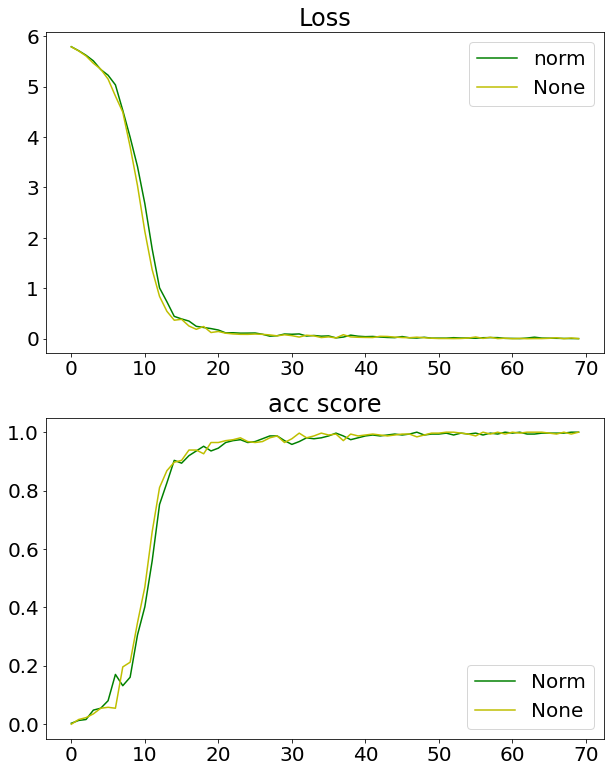

In [25]:
import matplotlib.pyplot as plt

plt.rc('font', size=20)        # 기본 폰트 크기
plt.rc('axes', labelsize=20)   # x,y축 label 폰트 크기
plt.rc('xtick', labelsize=20)  # x축 눈금 폰트 크기 
plt.rc('ytick', labelsize=20)  # y축 눈금 폰트 크기
plt.rc('legend', fontsize=20)  # 범례 폰트 크기
plt.rc('figure', titlesize=50) # figure title 폰트 크기

plt.figure(figsize=(10,13))

plt.subplot(2,1,1)
plt.plot(x, norm_loss, color='g', label='norm')
plt.plot(x, none_loss, color='y', label='None')
plt.title('Loss')
plt.legend()

plt.subplot(2,1,2)
plt.plot(x, norm_acc, color='g', label='Norm')
plt.plot(x, none_acc, color='y', label='None')
plt.title('acc score')
plt.legend()

plt.savefig('./myfigure.png', transparent = True)

## Save

In [11]:
torch.save({'epoch':epoch,
            'state_dict':state_dict,
            'optimizer': optimizer.state_dict(),
            'scaler': scaler.state_dict(),
     }, '/home/lab17/jupyter_home/Model/snacks_311_3.pth')


## Predict

In [12]:
pred_ensemble = []
batch_size = 34
# Test
test_dataset = Custom_dataset(np.array(test_imgs), np.array(["tmp"]*len(test_imgs)), mode='test')
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)

model_test = Network(mode = 'test').to(device)
model_test.load_state_dict(torch.load('/home/lab17/jupyter_home/Model/snacks_311_3.pth')['state_dict'])
model_test.eval()
f_pred = []
pred_prob = []

with torch.no_grad():
    for batch in (test_loader):
        x = torch.tensor(batch[0], dtype = torch.float32, device = device)
        with torch.cuda.amp.autocast():
            pred = model_test(x)
            pred_prob.extend(pred.detach().cpu().numpy())
        f_pred.extend(pred.argmax(1).detach().cpu().numpy().tolist())

In [13]:
# label_decoder = {val:key for key, val in label_unique.items()}

f_result = [train_dict[result] for result in f_pred]

In [14]:
f_result

['유기농 쌀떡뻥 25g',
 '노브랜드 자색고구마칩 110g',
 '오리온 오징어땅콩 3번들 294g',
 '유기농 쌀떡뻥 25g',
 '코코몽 유기농 달고나 25g',
 '(G) 노브랜드쿠키앤크림샌드720g',
 '(G) 노브랜드쿠키앤크림샌드720g']

##### 정답
- 감자깡
- 알새우칩
- 포스틱
- 사또밥
- 고래밥
- 빠삭칩
- 칸츄리콘

##### 1번째 : snacks_311

- '[농심] 새우깡90g'
- '[농심] 알새우칩 68g',
- '[농심] 포스틱 84g',
- '오리온 치즈뿌린 치킨팝 81g',
- '맘스케어 유기농까까 오리지날 43g',
- '노브랜드 달콤한꿀깨맛꽈배기 200 g',
- '노브랜드 땅콩카라멜콘 230 g'

##### 2번째 : snacks_311_2 (실패)

- ['단백질 오란다 100g',
- '유기농 쌀떡뻥 25g',
- '(G) 노브랜드쿠키앤크림샌드720g',
- '(G) 노브랜드쿠키앤크림샌드720g',
- '(G) 노브랜드쿠키앤크림샌드720g',
- '(G) 노브랜드쿠키앤크림샌드720g',
- '(G) 노브랜드쿠키앤크림샌드720g']

##### 3번째 : snacks_311_3

- ['유기농 쌀떡뻥 25g',
- '노브랜드 자색고구마칩 110g',
- '오리온 오징어땅콩 3번들 294g',
- '유기농 쌀떡뻥 25g',
- '코코몽 유기농 달고나 25g',
- '(G) 노브랜드쿠키앤크림샌드720g',
- '(G) 노브랜드쿠키앤크림샌드720g']